# Example of using library code

So far, we only provide channelmap editing for the Neuropixels probe family, and only the 4-shank Neuropixels probe is tested, so the following example codes use the 4-shank Neuropixels probe as the targeting probe.

## Basic

In [4]:
import numpy as np

from chmap.probe_npx import *

### Create an empty channelmap

In [ ]:
s = ChannelMap(24)
s

ChannelMap[4,2,640,384,0]

The above output printed the information of channelmap `s`, in the format `ChannelMap[S,C,R,H,E]`, where `S` is the number of total shanks, `C` is the number of total columns in a shank, `R` is the number of total rows in a shank, `H` is the number of total channels, and `E` is the number of selected electrodes.

For a valid channelmap, `H` and `E` should be equal.

### Load/Save a channelmap

`*.imro` (**im**ec **r**ead-**o**ut file) is the format of the Neuropixels channelmap used by 
[SpikeGLX](https://billkarsh.github.io/SpikeGLX/). 
[detail](https://billkarsh.github.io/SpikeGLX/help/imroTables/)

In [ ]:
s.save_imro('channelmap.imro')

We support read channelmap from different file format.

In [ ]:
# npx24_single_shank(0).save_imro('channelmap.imro')
s = ChannelMap.from_imro('channelmap.imro')

In [ ]:
_ = ChannelMap.from_meta('channelmap.meta') # from meta file from Spike outputs
_ = ChannelMap.parse('(24,384)(...)') # from raw imro table format

We support other output formats. The following code requires to install extra library (as optional dependency).

In [ ]:
# probeinterface
p = s.to_probe() # type: Probe
s = ChannelMap.from_probe(p)
p

Probe - IMEC - Neuropixels 2.0 - Four Shank - Prototype - 384ch - 1shanks

Or other channelmap data output formats.

In [ ]:
# pandas
s.to_pandas() # type: pd.Dataframe
# empty channels use -1

,shank,column,row,in_used,x,y
channel,,,,,,
0,0,0,0,True,0,0
1,0,1,0,True,32,0
2,0,0,1,True,0,15
3,0,1,1,True,32,15
4,0,0,2,True,0,30
...,...,...,...,...,...,...
379,0,1,141,True,32,2115
380,0,0,142,True,0,2130
381,0,1,142,True,32,2130


In [ ]:
# polars
s.to_polars() # type: pl.DataFrame
# empty channels use null

channel,shank,column,row,in_used,x,y
i64,i64,i64,i64,bool,i64,i64
0,0,0,0,true,0,0
1,0,1,0,true,32,0
2,0,0,1,true,0,15
3,0,1,1,true,32,15
4,0,0,2,true,0,30
5,0,1,2,true,32,30
6,0,0,3,true,0,45
7,0,1,3,true,32,45
8,0,0,4,true,0,60


### Select electrodes

Select an electrode as a readout channel

In [ ]:
s = ChannelMap(24)
e = s.add_electrode((0, 0, 0)) # select an electrode at shank 0, column 0 and row 9
e

Electrode[0,0,0]

The above output printed the information of an electrode in format `Electrode[S,C,R]`, where `S` is shank index, `C` in column index, and `R` is row index.

If a channel has been used, then you cannot select coorespond electrodes. A `ChannelHasUsedError` will be raised.

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')

try:
    s.add_electrode((0, 0, 0))
except ChannelHasUsedError as x:
    print(repr(x))
    print(x.electrode)

ChannelHasUsedError('Electrode[0,0,0]')
Electrode[0,0,0]


To ignore the selected electrode, you can use the `exist_ok` keyword in the `add_electrode` method.

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
e = s.add_electrode((0, 0, 0), exist_ok=True)
print(e)

Electrode[0,0,0]


It still raises a `ChannelHasUsedError` if the corresponding channel of a newly selected electrode is occupied. You can remove the previous one and re-select the new one.

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
e = None
try:
    s.add_electrode((1, 0, 0))
except ChannelHasUsedError as x:
    print(repr(x))
    s.del_electrode(x.electrode)
    e = s.add_electrode((1, 0, 0))
print(e)

ChannelHasUsedError('Electrode[0,0,144]')
Electrode[1,0,0]


### Access electrodes from a channelmap

Access the selected electrode via its channel ID.

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
print(s.channels[0])
print(s.channels[0:3])

Electrode[0,0,0]
[Electrode[0,0,0], Electrode[0,1,0], Electrode[0,0,1]]


Access the selected electrodes via its position.

In [ ]:
print(s.electrodes[0, 0, 0]) # shank, column, row
print(s.electrodes[0, 0, 0:3])

Electrode[0,0,0]
[Electrode[0,0,0], Electrode[0,0,1], Electrode[0,0,2]]


### Set electrode’s parameters

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
print(s.channels[0].in_used, s.channels[1].in_used)

# one by one
s.channels[0].in_used = False
print(s.channels[0].in_used)

# by a reference
e = Electrode(0, 0, 0)
e.in_used = False
s.channels[:] = e # apply to all selected electrodes
print(s.channels[1].in_used)

True True
False
False


### Electrode positions

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')
p = s.channel_pos # a (C, 2) position (um) array
print(p.shape)
p[:10, :]

(384, 2)


array([[ 0,  0],
       [32,  0],
       [ 0, 15],
       [32, 15],
       [ 0, 30],
       [32, 30],
       [ 0, 45],
       [32, 45],
       [ 0, 60],
       [32, 60]])

## Plotting

In [18]:
import matplotlib
import matplotlib.pyplot as plt
from chmap.probe_npx import plot

%matplotlib inline
rc = matplotlib.rc_params_from_file('channelmap.matplotlibrc', fail_on_error=True, use_default_template=True)

plot a channelmap.

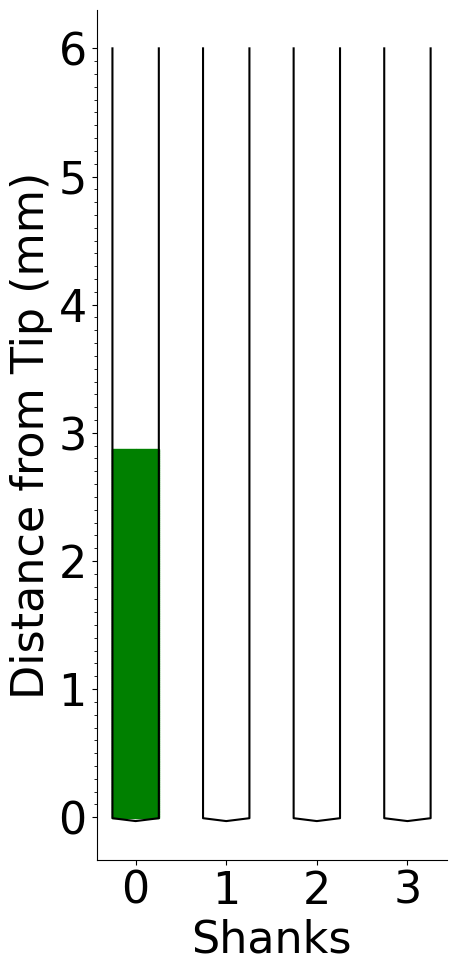

In [21]:
s = ChannelMap.from_imro('channelmap.imro')

with plt.rc_context(rc):
    fg, ax = plt.subplots()
    plot.plot_channelmap_block(ax, s, height=6, color='g', shank_width_scale=2)
    plot.plot_probe_shape(ax, s, height=6, color='k', label_axis=True, shank_width_scale=2)

plt.show()

plot a channelmap in other style.

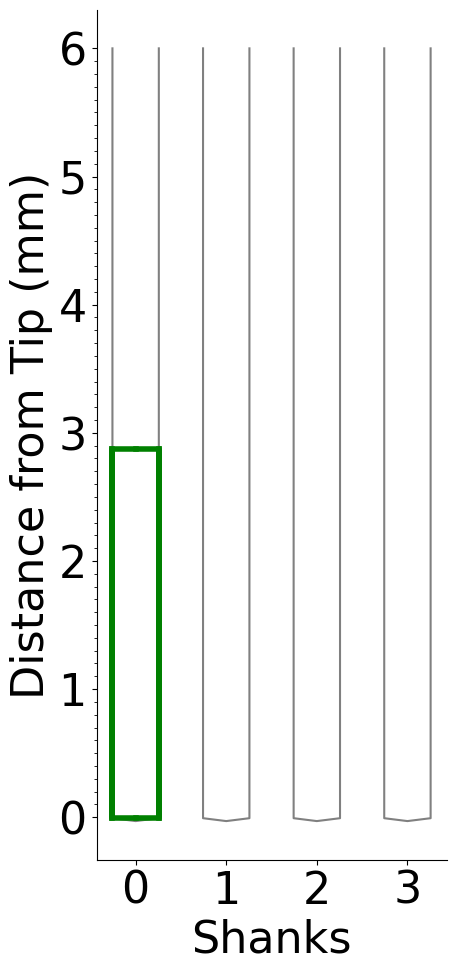

In [ ]:
s = ChannelMap.from_imro('channelmap.imro')

with plt.rc_context(rc):
    fg, ax = plt.subplots()

    plot.plot_probe_shape(ax, s, height=6, color='gray', label_axis=True, shank_width_scale=2)
    plot.plot_channelmap_grid(ax, s, height=6, color='g', lw=4, shank_width_scale=2)


plt.show()

## Generate a Channelmap

### Typical channelmap

In [ ]:
print(print_probe([
    npx24_single_shank(0), 
    npx24_stripe(0)
], truncate='top'))

190▕█▏▕ ▏▕ ▏▕ ▏190▕ ▏▕ ▏▕ ▏▕ ▏
188▕█▏▕ ▏▕ ▏▕ ▏188▕ ▏▕ ▏▕ ▏▕ ▏
186▕█▏▕ ▏▕ ▏▕ ▏186▕ ▏▕ ▏▕ ▏▕ ▏
184▕█▏▕ ▏▕ ▏▕ ▏184▕ ▏▕ ▏▕ ▏▕ ▏
182▕█▏▕ ▏▕ ▏▕ ▏182▕ ▏▕ ▏▕ ▏▕ ▏
180▕█▏▕ ▏▕ ▏▕ ▏180▕ ▏▕ ▏▕ ▏▕ ▏
178▕█▏▕ ▏▕ ▏▕ ▏178▕ ▏▕ ▏▕ ▏▕ ▏
176▕█▏▕ ▏▕ ▏▕ ▏176▕ ▏▕ ▏▕ ▏▕ ▏
174▕█▏▕ ▏▕ ▏▕ ▏174▕ ▏▕ ▏▕ ▏▕ ▏
172▕█▏▕ ▏▕ ▏▕ ▏172▕ ▏▕ ▏▕ ▏▕ ▏
170▕█▏▕ ▏▕ ▏▕ ▏170▕ ▏▕ ▏▕ ▏▕ ▏
168▕█▏▕ ▏▕ ▏▕ ▏168▕ ▏▕ ▏▕ ▏▕ ▏
166▕█▏▕ ▏▕ ▏▕ ▏166▕ ▏▕ ▏▕ ▏▕ ▏
164▕█▏▕ ▏▕ ▏▕ ▏164▕ ▏▕ ▏▕ ▏▕ ▏
162▕█▏▕ ▏▕ ▏▕ ▏162▕ ▏▕ ▏▕ ▏▕ ▏
160▕█▏▕ ▏▕ ▏▕ ▏160▕ ▏▕ ▏▕ ▏▕ ▏
158▕█▏▕ ▏▕ ▏▕ ▏158▕ ▏▕ ▏▕ ▏▕ ▏
156▕█▏▕ ▏▕ ▏▕ ▏156▕ ▏▕ ▏▕ ▏▕ ▏
154▕█▏▕ ▏▕ ▏▕ ▏154▕ ▏▕ ▏▕ ▏▕ ▏
152▕█▏▕ ▏▕ ▏▕ ▏152▕ ▏▕ ▏▕ ▏▕ ▏
150▕█▏▕ ▏▕ ▏▕ ▏150▕ ▏▕ ▏▕ ▏▕ ▏
148▕█▏▕ ▏▕ ▏▕ ▏148▕ ▏▕ ▏▕ ▏▕ ▏
146▕█▏▕ ▏▕ ▏▕ ▏146▕ ▏▕ ▏▕ ▏▕ ▏
144▕█▏▕ ▏▕ ▏▕ ▏144▕ ▏▕ ▏▕ ▏▕ ▏
142▕█▏▕ ▏▕ ▏▕ ▏142▕ ▏▕ ▏▕ ▏▕ ▏
140▕█▏▕ ▏▕ ▏▕ ▏140▕ ▏▕ ▏▕ ▏▕ ▏
138▕█▏▕ ▏▕ ▏▕ ▏138▕ ▏▕ ▏▕ ▏▕ ▏
136▕█▏▕ ▏▕ ▏▕ ▏136▕ ▏▕ ▏▕ ▏▕ ▏
134▕█▏▕ ▏▕ ▏▕ ▏134▕ ▏▕ ▏▕ ▏▕ ▏
132▕█▏▕ ▏▕ ▏▕ ▏132▕ ▏▕ ▏▕ ▏▕ ▏
130▕█▏▕ ▏▕ ▏▕ ▏130▕ ▏▕ ▏▕ ▏▕ ▏
128▕█▏▕ ▏▕ ▏▕ ▏128▕ ▏▕ ▏▕ ▏▕ ▏
126▕█▏▕ 

### Uniform channelmaps

All selected electrodes are distributed uniformly in a particular density.

In [ ]:
print(print_probe([
    # 1/2
    npx24_half_density(shank=0),
    npx24_half_density(shank=(0, 1)),
    # 1/4
    s := npx24_quarter_density(shank=0),
    npx24_quarter_density(shank=(0, 2)),
    npx24_quarter_density(None),
    # 1/8
    npx24_one_eighth_density()
], truncate='top'))

638▕ ▏▕ ▏▕ ▏▕ ▏638▕ ▏▕ ▏▕ ▏▕ ▏638▕▘▏▕ ▏▕ ▏▕ ▏638▕ ▏▕ ▏▕ ▏▕ ▏638▕ ▏▕ ▏▕ ▏▕ ▏638▕ ▏▕ ▏▕ ▏▕ ▏
636▕ ▏▕ ▏▕ ▏▕ ▏636▕ ▏▕ ▏▕ ▏▕ ▏636▕▝▏▕ ▏▕ ▏▕ ▏636▕ ▏▕ ▏▕ ▏▕ ▏636▕ ▏▕ ▏▕ ▏▕ ▏636▕ ▏▕ ▏▕ ▏▕ ▏
634▕ ▏▕ ▏▕ ▏▕ ▏634▕ ▏▕ ▏▕ ▏▕ ▏634▕▘▏▕ ▏▕ ▏▕ ▏634▕ ▏▕ ▏▕ ▏▕ ▏634▕ ▏▕ ▏▕ ▏▕ ▏634▕ ▏▕ ▏▕ ▏▕ ▏
632▕ ▏▕ ▏▕ ▏▕ ▏632▕ ▏▕ ▏▕ ▏▕ ▏632▕▝▏▕ ▏▕ ▏▕ ▏632▕ ▏▕ ▏▕ ▏▕ ▏632▕ ▏▕ ▏▕ ▏▕ ▏632▕ ▏▕ ▏▕ ▏▕ ▏
630▕ ▏▕ ▏▕ ▏▕ ▏630▕ ▏▕ ▏▕ ▏▕ ▏630▕▘▏▕ ▏▕ ▏▕ ▏630▕ ▏▕ ▏▕ ▏▕ ▏630▕ ▏▕ ▏▕ ▏▕ ▏630▕ ▏▕ ▏▕ ▏▕ ▏
628▕ ▏▕ ▏▕ ▏▕ ▏628▕ ▏▕ ▏▕ ▏▕ ▏628▕▝▏▕ ▏▕ ▏▕ ▏628▕ ▏▕ ▏▕ ▏▕ ▏628▕ ▏▕ ▏▕ ▏▕ ▏628▕ ▏▕ ▏▕ ▏▕ ▏
626▕ ▏▕ ▏▕ ▏▕ ▏626▕ ▏▕ ▏▕ ▏▕ ▏626▕▘▏▕ ▏▕ ▏▕ ▏626▕ ▏▕ ▏▕ ▏▕ ▏626▕ ▏▕ ▏▕ ▏▕ ▏626▕ ▏▕ ▏▕ ▏▕ ▏
624▕ ▏▕ ▏▕ ▏▕ ▏624▕ ▏▕ ▏▕ ▏▕ ▏624▕▝▏▕ ▏▕ ▏▕ ▏624▕ ▏▕ ▏▕ ▏▕ ▏624▕ ▏▕ ▏▕ ▏▕ ▏624▕ ▏▕ ▏▕ ▏▕ ▏
622▕ ▏▕ ▏▕ ▏▕ ▏622▕ ▏▕ ▏▕ ▏▕ ▏622▕▘▏▕ ▏▕ ▏▕ ▏622▕ ▏▕ ▏▕ ▏▕ ▏622▕ ▏▕ ▏▕ ▏▕ ▏622▕ ▏▕ ▏▕ ▏▕ ▏
620▕ ▏▕ ▏▕ ▏▕ ▏620▕ ▏▕ ▏▕ ▏▕ ▏620▕▝▏▕ ▏▕ ▏▕ ▏620▕ ▏▕ ▏▕ ▏▕ ▏620▕ ▏▕ ▏▕ ▏▕ ▏620▕ ▏▕ ▏▕ ▏▕ ▏
618▕ ▏▕ ▏▕ ▏▕ ▏618▕ ▏▕ ▏▕ ▏▕ ▏618▕▘▏▕ ▏▕ ▏▕ ▏618▕ ▏▕ ▏▕ ▏▕ ▏618▕ ▏▕ ▏▕ ▏▕ ▏618▕ ▏▕ ▏▕ ▏▕ ▏

Notice the the channelmap `s` is an incompleted channelmap, because its number of selected electrodes do not reach the number of required channels.

In [ ]:
s

ChannelMap[4,2,640,384,320]

## Electrode selection with a blueprint

In [1]:
from chmap.probe_npx.desp import NpxProbeDesp

In [7]:
D = NpxProbeDesp()
C = ChannelMap.from_imro('Fig3_example.imro')
Q = D.electrode_from_numpy(D.all_electrodes(C), np.load('Fig3_example.policy.npy'))

A blueprint `Q` is a list of electrodes that also carried the selection policy. It is not easy to make a new blueprint from zero. It is more easy to make from the application. Here, we use built one to demonstrate `D` usage.

### Electrode selection

In [8]:
s = D.select_electrodes(C, Q)
print(print_probe([C, s], truncate='top'))

334▕ ▏▕ ▏▕ ▏▕ ▏334▕ ▏▕ ▏▕ ▏▕▗▏
332▕ ▏▕ ▏▕ ▏▕ ▏332▕ ▏▕ ▏▕ ▏▕▘▏
330▕ ▏▕ ▏▕ ▏▕ ▏330▕ ▏▕ ▏▕ ▏▕▀▏
328▕ ▏▕ ▏▕ ▏▕ ▏328▕ ▏▕ ▏▕ ▏▕▖▏
326▕ ▏▕ ▏▕ ▏▕ ▏326▕ ▏▕ ▏▕ ▏▕▞▏
324▕ ▏▕ ▏▕ ▏▕ ▏324▕ ▏▕ ▏▕ ▏▕ ▏
322▕ ▏▕ ▏▕ ▏▕ ▏322▕ ▏▕ ▏▕ ▏▕ ▏
320▕ ▏▕ ▏▕ ▏▕ ▏320▕ ▏▕ ▏▕ ▏▕▘▏
318▕ ▏▕ ▏▕ ▏▕ ▏318▕ ▏▕ ▏▕ ▏▕▄▏
316▕ ▏▕ ▏▕ ▏▕ ▏316▕ ▏▕ ▏▕ ▏▕ ▏
314▕ ▏▕ ▏▕ ▏▕ ▏314▕ ▏▕ ▏▕ ▏▕▖▏
312▕ ▏▕ ▏▕ ▏▕ ▏312▕ ▏▕ ▏▕ ▏▕ ▏
310▕ ▏▕ ▏▕▄▏▕ ▏310▕ ▏▕ ▏▕▗▏▕▝▏
308▕ ▏▕ ▏▕▐▏▕ ▏308▕ ▏▕ ▏▕▙▏▕ ▏
306▕ ▏▕ ▏▕▌▏▕ ▏306▕ ▏▕ ▏▕ ▏▕ ▏
304▕ ▏▕ ▏▕▗▏▕ ▏304▕ ▏▕ ▏▕ ▏▕ ▏
302▕ ▏▕ ▏▕ ▏▕ ▏302▕ ▏▕ ▏▕▖▏▕ ▏
300▕ ▏▕ ▏▕ ▏▕ ▏300▕ ▏▕ ▏▕▝▏▕▘▏
298▕ ▏▕ ▏▕▗▏▕ ▏298▕ ▏▕ ▏▕▚▏▕ ▏
296▕ ▏▕ ▏▕▖▏▕ ▏296▕ ▏▕ ▏▕ ▏▕ ▏
294▕ ▏▕ ▏▕ ▏▕ ▏294▕ ▏▕ ▏▕ ▏▕ ▏
292▕ ▏▕ ▏▕ ▏▕ ▏292▕ ▏▕ ▏▕ ▏▕ ▏
290▕ ▏▕ ▏▕▖▏▕ ▏290▕ ▏▕ ▏▕ ▏▕ ▏
288▕ ▏▕ ▏▕ ▏▕ ▏288▕ ▏▕ ▏▕▗▏▕ ▏
286▕ ▏▕ ▏▕ ▏▕ ▏286▕ ▏▕ ▏▕ ▏▕ ▏
284▕ ▏▕ ▏▕▖▏▕ ▏284▕ ▏▕ ▏▕ ▏▕ ▏
282▕ ▏▕ ▏▕ ▏▕ ▏282▕ ▏▕ ▏▕ ▏▕ ▏
280▕ ▏▕ ▏▕ ▏▕ ▏280▕ ▏▕ ▏▕ ▏▕ ▏
278▕ ▏▕ ▏▕ ▏▕ ▏278▕ ▏▕ ▏▕ ▏▕ ▏
276▕ ▏▕ ▏▕▖▏▕ ▏276▕ ▏▕ ▏▕ ▏▕ ▏
274▕ ▏▕ ▏▕ ▏▕ ▏274▕ ▏▕ ▏▕▞▏▕ ▏
272▕ ▏▕ ▏▕▖▏▕ ▏272▕ ▏▕ ▏▕ ▏▕ ▏
270▕ ▏▕ 

### Visualize the blueprint

plot the blueprint on probe

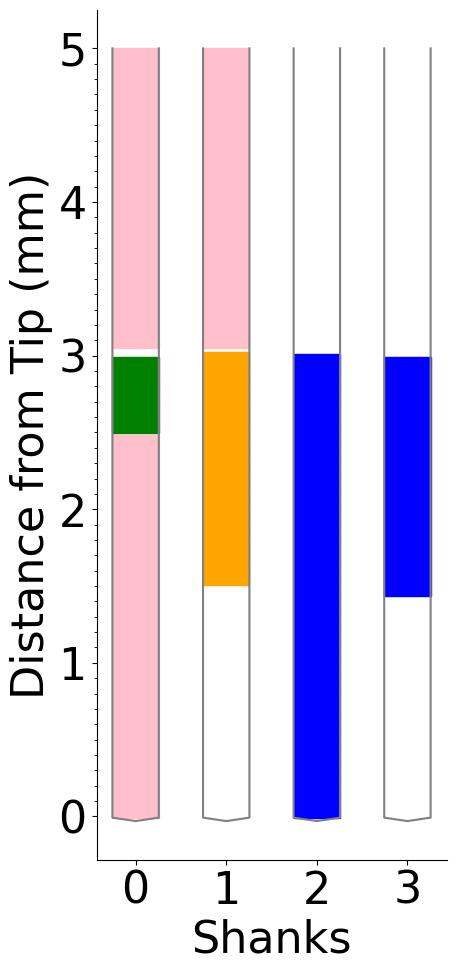

In [23]:
with plt.rc_context(rc):
    fg, ax = plt.subplots()

    height = 5
    plot.plot_policy_area(ax, C.probe_type, Q, height=height, shank_width_scale=2)
    plot.plot_probe_shape(ax, C.probe_type, height=height, color='gray', label_axis=True, shank_width_scale=2)


plt.show()